<div class="span5 alert alert-success">
    
***
# <span style = 'color:darkblue'> <center> $ \textrm {Import Required Libraries} $

***
</span>
</div>

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import operator

from sklearn import linear_model
from sklearn.metrics import auc, roc_curve
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from IPython.display import Markdown, display

%matplotlib inline

<div class="span5 alert alert-success">
    
***
# <span style = 'color:darkblue'> <center> $ \textrm {Function Definitions} $

***
</span>
</div>

In [46]:
def zeroDiagonal(dataTable, dimension):
    ''' Replace Dataframe n x n matrix diagonal values with zero '''
    for i in range(dimension):
        for j in range(dimension):
            if i==j:
                dataTable.iloc[i,j]=0

    return(dataTable)

<div class="span5 alert alert-success">
    
***
# <span style = 'color:darkblue'> <center> $ \textrm {Exploratory Data Analysis} $

***
</span>
</div>

## <center> $ \color{darkblue} {\textrm {Read file, add feature names, and examine data with  'describe()'  method} } $

In [47]:
# Load the Adult income dataset to a dataframe and specifiy column names
adultIncome_df = pd.read_csv('../UCI-Adult-Income/adult_data_copy.csv', 
                 header= None, index_col = False,
                 names =['Age',
                         'Workclass',
                         'FNL-Wgt',
                         'Education', 
                         'Education-Years', 
                         'Marital Status',
                         'Occupation',
                         'Relationship',
                         'Race', 
                         'Gender', 
                         'Capital-Gain',
                         'Capital-Loss', 
                         'Hours-per-Week', 
                         'Citizenship',
                         'Income50K'])
adultIncome_df.head()

,Age,Workclass,FNL-Wgt,Education,Education-Years,Marital Status,Occupation,Relationship,Race,Gender,Capital-Gain,Capital-Loss,Hours-per-Week,Citizenship,Income50K
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [48]:
# Replce category name'?' with 'Other'
for col in adultIncome_df.columns:
    if adultIncome_df[col].dtype == 'object':
        adultIncome_df[col]= (adultIncome_df[col].str.strip()).str.replace('?', col+'-Other')

<div class="span5 alert alert-success">
    
***
# <span style = 'color:darkblue'> <center> $ \textrm {Data Story} $

***
</span>
</div>

In [49]:
# Replace Dataframe n x n matrix diagonal values with zero to allow other features correlation amplified
IncomeCorr = zeroDiagonal(adultIncome_df.corr(),6)
display(IncomeCorr, \
        Markdown(r'$\\ \color {darkblue} {\textbf {From the Correlation table highest correlation coefficient of 0.148 is between Education-Years and Hours-per-Week with diagonal }} $'))
display(Markdown(r'$\\ \color {darkblue} {\textbf {values set to zero. }} $'))

,Age,FNL-Wgt,Education-Years,Capital-Gain,Capital-Loss,Hours-per-Week
Age,0.000000,-0.076646,0.036527,0.077674,0.057775,0.068756
FNL-Wgt,-0.076646,0.000000,-0.043195,0.000432,-0.010252,-0.018768
Education-Years,0.036527,-0.043195,0.000000,0.122630,0.079923,0.148123
Capital-Gain,0.077674,0.000432,0.122630,0.000000,-0.031615,0.078409
Capital-Loss,0.057775,-0.010252,0.079923,-0.031615,0.000000,0.054256
Hours-per-Week,0.068756,-0.018768,0.148123,0.078409,0.054256,0.000000


$\\ \color {darkblue} {\textbf {From the Correlation table highest correlation coefficient of 0.148 is between Education-Years and Hours-per-Week with diagonal }} $

$\\ \color {darkblue} {\textbf {values set to zero. }} $

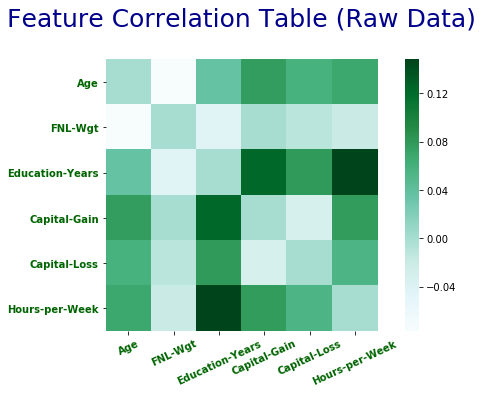

In [50]:
# Feature Correlation Analysis
_ = plt.figure(figsize = (10,5))
_ = plt.title('Feature Correlation Table (Raw Data)\n', size = 25, color = 'darkblue')
_ = sns.heatmap(IncomeCorr, square=True, cmap='BuGn')
_ = plt.xticks(rotation = 25, color = 'darkgreen', fontweight = 'bold')
_ = plt.yticks(color = 'darkgreen', fontweight = 'bold')
_ = plt.show()

In [51]:
gender = round(pd.crosstab(adultIncome_df.Gender, \
                           adultIncome_df.Income50K).div(pd.crosstab(adultIncome_df.Gender, \
                                                                     adultIncome_df.Income50K).apply(sum,1),
                                                         0),\
               2) *100

gender.sort_values(by = '>50K', inplace = True)
_ = gender.T

<ul></ul> <center> $ \color{darkblue} {\Large { \textit {Income and Gender} } }  $

Gender,Female,Male
Income50K,,
<=50K,89.0,69.0
>50K,11.0,31.0


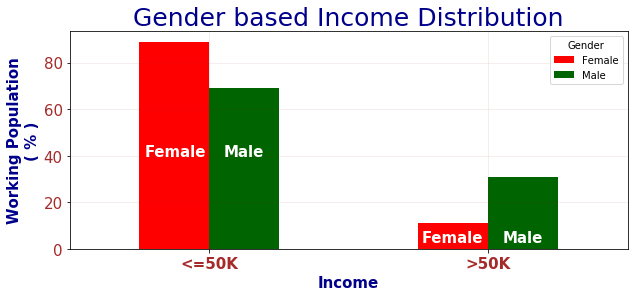

$ \color {darkblue} { \textrm {This data and plot indicates a clear income inequality} \
\textrm {between male and female individuals earning more than \$50K. } } \\ $

In [52]:
display(Markdown(r'<ul></ul> <center> $ \color{darkblue} {\Large { \textit {Income and Gender} } }  $'))
display(gender.T)
# use transpose for side by side gender plot
_ = gender.T.plot(kind ='bar', color = ['r','darkgreen'], figsize = (10,4))
_ = plt.title('Gender based Income Distribution', size = 25, color = 'darkblue')
_ = plt.xlabel('Income', size = 15, color = 'darkblue', fontweight = 'bold')
_ = plt.ylabel('Working Population\n( % )', size = 15, color = 'darkblue', fontweight = 'bold')
_ = plt.xticks(rotation =0, color = 'brown', size = 15, fontweight = 'bold')
_ = plt.yticks(color = 'brown', size = 15)
_ = plt.text(-0.23, 40, 'Female', size = 15, color='w', fontweight = 'bold')
_ = plt.text(0.05, 40, 'Male', size = 15, color='w', fontweight = 'bold')
_ = plt.text(0.76, 3, 'Female', size = 15, color='w', fontweight = 'bold')
_ = plt.text(1.05, 3, 'Male', size = 15, color='w', fontweight = 'bold')
_ = plt.grid(alpha = 0.1, color = 'brown')
_ = plt.show()
display(Markdown(r'$ \color {darkblue} { \textrm {This data and plot indicates a clear income inequality} \
\textrm {between male and female individuals earning more than \$50K. } } \\ $'))

<ul></ul><center> $ \color{darkblue} {\Large { \textit {Income and Race} } }  $

$ \color{darkblue} { \textrm {Here, data and plot reveal highest income earners have identified } \
\textrm {themselfs as White and Asian.} \
\\ \textrm {For remaining races, income earnings exceeding \$50K are below 12% of their working population.} } \\ $

Race,Other,Amer-Indian-Eskimo,Black,White,Asian-Pac-Islander
Income50K,,,,,
<=50K,91.0,88.0,88.0,74.0,73.0
>50K,9.0,12.0,12.0,26.0,27.0


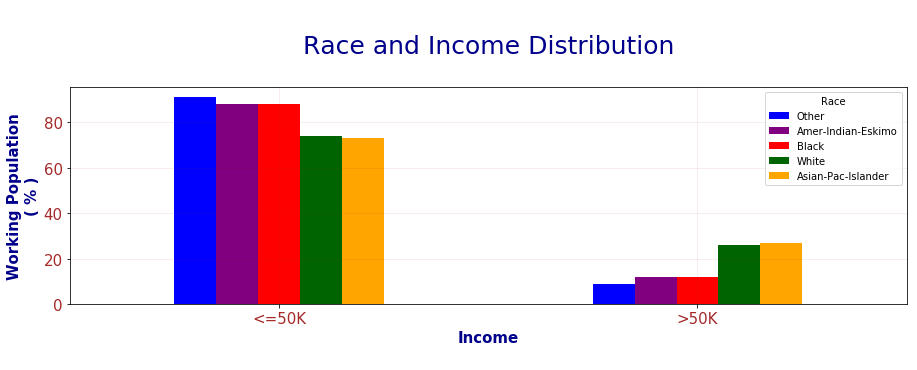

In [53]:
race = round(pd.crosstab(adultIncome_df.Race, \
                           adultIncome_df.Income50K).div(pd.crosstab(adultIncome_df.Race, \
                                                                     adultIncome_df.Income50K).apply(sum,1),
                                                         0),\
               2) *100

race.sort_values(by = '>50K', inplace = True)
display(Markdown(r'<ul></ul><center> $ \color{darkblue} {\Large { \textit {Income and Race} } }  $'))
display(Markdown(r'$ \color{darkblue} { \textrm {Here, data and plot reveal highest income earners have identified } \
\textrm {themselfs as White and Asian.} \
\\ \textrm {For remaining races, income earnings exceeding \$50K are below 12% of their working population.} } \\ $'))
display(race.T)
_ = race.T.plot(kind ='bar', color = ['b','purple','r','darkgreen','orange'], figsize = (15,4))
_ = plt.title('\nRace and Income Distribution\n', size = 25, color = 'darkblue')
_ = plt.xlabel('Income\n', size = 15, color = 'darkblue', fontweight = 'bold')
_ = plt.ylabel('Working Population\n( % )', size = 15, color = 'darkblue', fontweight = 'bold')
_ = plt.xticks(rotation = 0, color = 'brown', size = 15)
_ = plt.yticks(color = 'brown', size = 15)
_ = plt.grid(alpha = 0.1, color = 'brown')

<ul></ul><center> $ \color{darkblue} {\Large { \textit {Income and Education} } }  $

$ \color {darkblue} { \textrm {This data and plot indicates direct proportionality of income} \
\textrm {to education. As years of education increases, individual } \\ \textrm {earnings converges to exceed \$50K. } } \\ $

Education-Years,1,2,3,5,7,4,6,8,9,10,12,11,13,14,15,16
Income50K,,,,,,,,,,,,,,,,
<=50K,100.0,96.0,95.0,95.0,95.0,94.0,93.0,92.0,84.0,81.0,75.0,74.0,59.0,44.0,27.0,26.0
>50K,0.0,4.0,5.0,5.0,5.0,6.0,7.0,8.0,16.0,19.0,25.0,26.0,41.0,56.0,73.0,74.0


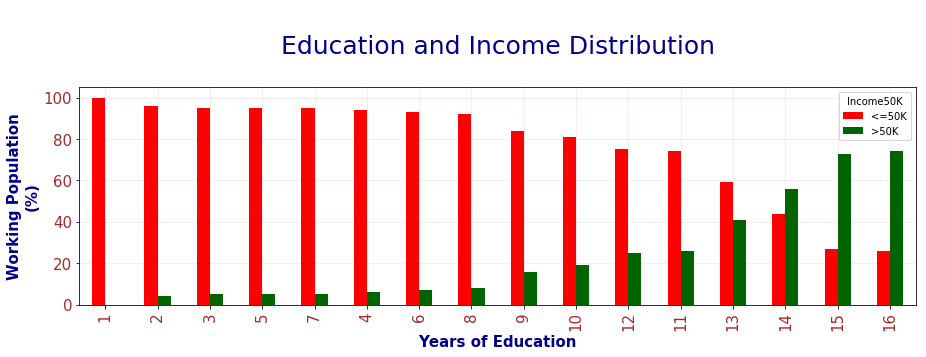

In [54]:
edu = round(pd.crosstab(adultIncome_df['Education-Years'], \
                           adultIncome_df.Income50K).div(pd.crosstab(adultIncome_df['Education-Years'], \
                                                                     adultIncome_df.Income50K).apply(sum,1),
                                                         0),\
               2) *100

edu.sort_values(by = '>50K', inplace = True)
display(Markdown(r'<ul></ul><center> $ \color{darkblue} {\Large { \textit {Income and Education} } }  $'))
display(Markdown(r'$ \color {darkblue} { \textrm {This data and plot indicates direct proportionality of income} \
\textrm {to education. As years of education increases, individual } \\ \textrm {earnings converges to exceed \$50K. } } \\ $'))
display(edu.T)
_ = edu.plot(kind ='bar', color = ['r','darkgreen'], figsize = (15,4))
_ = plt.title('\nEducation and Income Distribution\n', size = 25, color = 'darkblue')
_ = plt.xlabel('Years of Education', size = 15, color = 'darkblue', fontweight = 'bold')
_ = plt.ylabel('Working Population\n(%)', size = 15, color = 'darkblue', fontweight = 'bold')
_ = plt.xticks(color = 'brown', size = 15)
_ = plt.yticks(color = 'brown', size = 15)
_ = plt.grid(alpha = 0.1, color = 'brown')

<ul></ul><center> $ \color{darkblue} {\Large { \textit {Income and Age} } }  $

$ \color {darkblue} { \textrm {Middle age indicates higheset individual income.} \
\\ \textrm {Most individuals between ages of 35 and 62 years appear to have highest income exceeding \$50K. } } \\ $

Age,17,18,19,20,21,22,23,24,25,26,...,80,81,82,83,84,85,86,87,88,90
Income50K,,,,,,,,,,,,,,,,,,,,,
<=50K,100.0,100.0,100.0,100.0,100.0,98.0,99.0,96.0,94.0,92.0,...,91.0,85.0,100.0,67.0,90.0,100.0,100.0,100.0,100.0,81.0
>50K,0.0,0.0,0.0,0.0,0.0,2.0,1.0,4.0,6.0,8.0,...,9.0,15.0,0.0,33.0,10.0,0.0,0.0,0.0,0.0,19.0


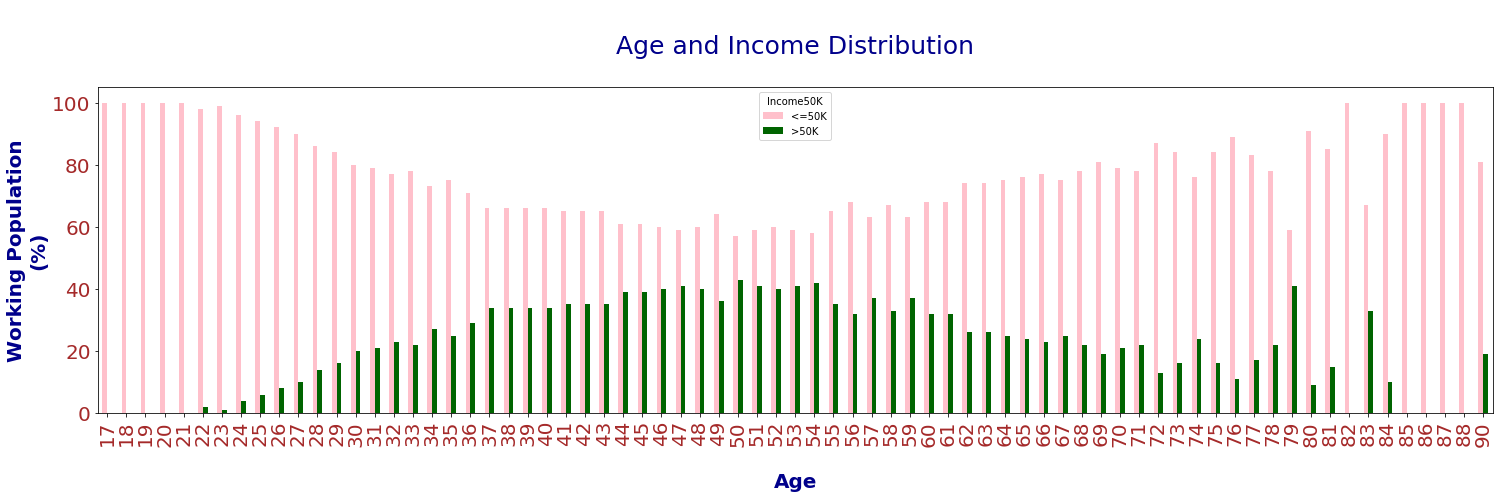

In [55]:
age = round(pd.crosstab(adultIncome_df.Age, \
                           adultIncome_df.Income50K).div(pd.crosstab(adultIncome_df.Age, \
                                                                     adultIncome_df.Income50K).apply(sum,1),
                                                         0),\
               2) *100
display(Markdown(r'<ul></ul><center> $ \color{darkblue} {\Large { \textit {Income and Age} } }  $'))
display(Markdown(r'$ \color {darkblue} { \textrm {Middle age indicates higheset individual income.} \
\\ \textrm {Most individuals between ages of 35 and 62 years appear to have highest income exceeding \$50K. } } \\ $'))
display(age.T)
_ = age.plot(kind ='bar', color = ['pink','darkgreen'], figsize = (25, 6))
_ = plt.title('\nAge and Income Distribution\n', size = 25, color = 'darkblue')
_ = plt.xlabel('\nAge', size = 20, color = 'darkblue', fontweight = 'bold')
_ = plt.ylabel('Working Population\n(%)', size = 20, color = 'darkblue', fontweight = 'bold')
_ = plt.xticks(color = 'brown', size = 20)
_ = plt.yticks(color = 'brown', size = 20)

### <span style='color:darkblue'> $ \textrm {Convert Features with Categorical Data to Binary Values} $ </span>

In [56]:
# avoid error if column already removed
if 'Education' in adultIncome_df.columns:
    # remove column 'Education' since it is represented by 'Education-Years'
    adultIncome_df.drop(['Education'], axis = 1, inplace=True)
    print(adultIncome_df.columns)

Index(['Age', 'Workclass', 'FNL-Wgt', 'Education-Years', 'Marital Status',
       'Occupation', 'Relationship', 'Race', 'Gender', 'Capital-Gain',
       'Capital-Loss', 'Hours-per-Week', 'Citizenship', 'Income50K'],
      dtype='object')


In [57]:
# Create categorical dummies for binary columns
for col in adultIncome_df.columns:
    # skip over columns with numeric data
    if pd.api.types.is_numeric_dtype(adultIncome_df[col].dtype) == False:  
        # get dummies for each category drop first category to avoid overfitting
        dummies = pd.get_dummies(adultIncome_df[[col]], prefix_sep='_', drop_first = True)
        
        for dcol in dummies.columns:
            # convert to 'category type'
            dm_cat = dummies[dcol].astype('category')
            # insert new columns in the original data frame for analysis
            adultIncome_df.insert(adultIncome_df.columns.get_loc(col), dcol, dm_cat.values)
    
        # remove category column from dataFrame
        adultIncome_df.drop([col], axis=1, inplace=True)

### <span style = 'color:darkblue'> $ \textrm {Pre-Process Training and Test data} $

In [58]:
# decimal places for rounding numbers
decimals = 4

# Feature columns - remove target columns from column list
feature_column_names = [c for c in adultIncome_df.columns if c!='Income50K_>50K']
target_column_name = 'Income50K_>50K'

# Use all features
X_data = adultIncome_df[feature_column_names] 
Y_data = adultIncome_df[[target_column_name]] 

# split data for training and test
X_train_data, X_test_data, Y_train_data, Y_test_data = train_test_split(X_data, \
                                                                        Y_data, \
                                                                        test_size = 0.0017, \
                                                                        random_state = 42)
SampleSize = X_test_data.shape[0]
print('SampleSize:     %d' % SampleSize)
featureCount = len(adultIncome_df.columns) - 1
print('Feature Count :', featureCount)

SampleSize:     56
Feature Count : 85


### <span style = 'color:darkblue'> $ \textrm {Correlation of Features with Categorical Data Converted to Binary Values} $

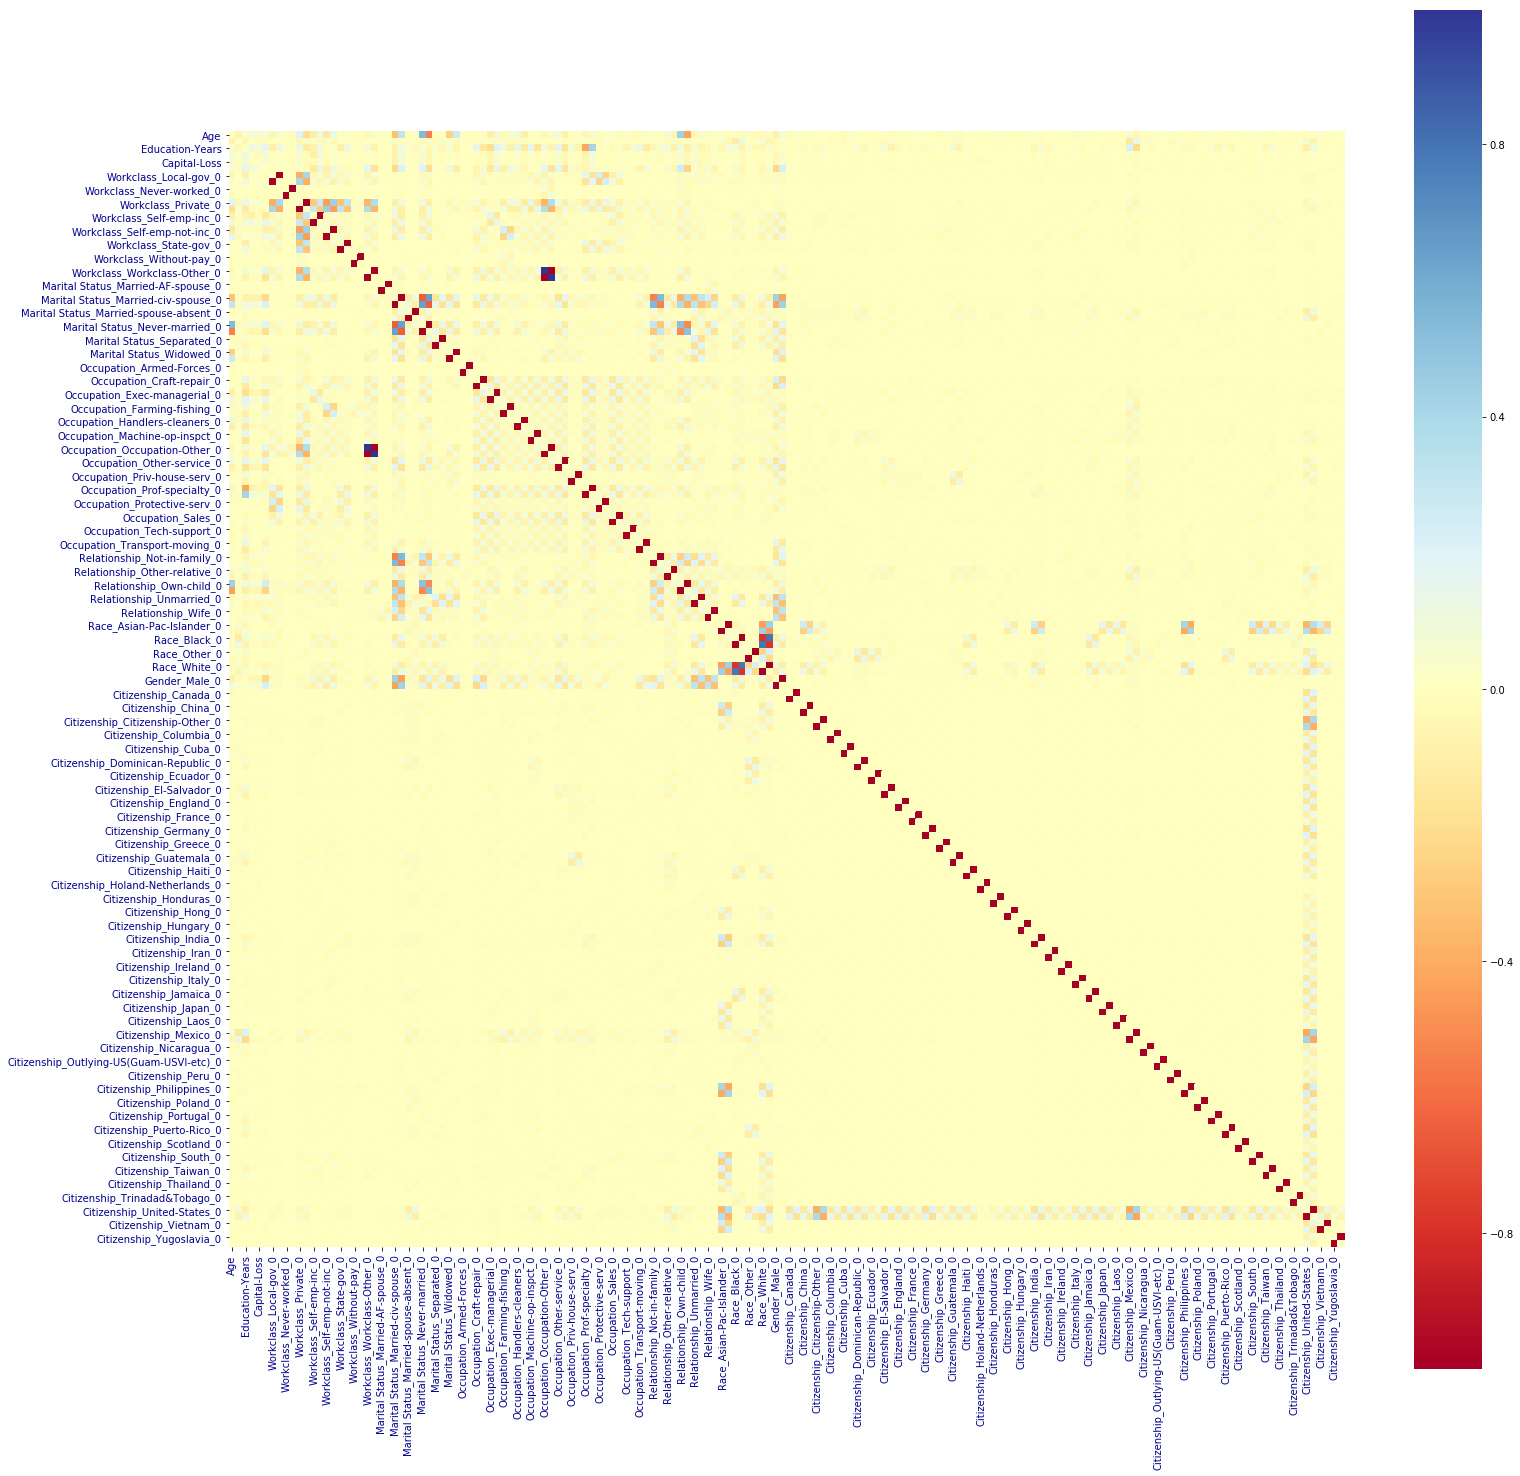

In [59]:
trainData = pd.get_dummies(X_train_data).corr()
trainData = zeroDiagonal(trainData, len(trainData))
_ = plt.figure(figsize = (25,25))
# Binary Feature Correlation Analysis
_ = sns.heatmap(trainData, square = True, cmap='RdYlBu')
_ = plt.xticks(color = 'darkblue')
_ = plt.yticks(color = 'darkblue')
_ = plt.show()